In [1]:
# import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

# random seeds
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
# define non-linear function using 3 input variables
def nonlinear_function(X):
    return 2 * tf.math.sin(X[:, 0]) + 3 * tf.math.cos(X[:, 1]) + \
           0.5 * tf.square(X[:, 2]) + 0.1 * X[:, 0] * X[:, 1] * X[:, 2]

# generate synthetic dataset
def make_data(n=1000):
    inputs = tf.random.uniform((n, 3), minval=-2, maxval=2)
    targets_clean = nonlinear_function(inputs)
    targets_noisy = targets_clean + tf.random.normal((n,), stddev=0.5)
    return tf.cast(inputs, tf.float32), tf.reshape(targets_noisy, (-1, 1))

# generate training and test data
X_train, y_train = make_data(1000)
X_test, y_test = make_data(200)

# shapes of the generated data
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1000, 3)
Test shape: (200, 3)


In [3]:
# build a 3-layer neural network using the Functional API
def build_functional_net(input_dim=3, hidden1=10, hidden2=5, output_dim=1):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(hidden1, activation='relu', kernel_initializer='he_normal')(inputs)
    x = tf.keras.layers.Dense(hidden2, activation='relu', kernel_initializer='he_normal')(x)
    outputs = tf.keras.layers.Dense(output_dim, kernel_initializer='he_normal')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="FlexibleModel")

# initialize model
model_fn = build_functional_net()
model_fn.summary()

Model: "FlexibleModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

In [4]:
# compile the model with MSE and MAE as metrics
model_fn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='mse',
    metrics=['mae']
)

# created TensorFlow data pipelines for training and validation
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

# defining callbacks for early stopping and learning rate reduction
callbacks_fn = [
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, factor=0.5, min_lr=0.0001)
]

In [5]:
# train the model using built-in .fit method
start = time.time()
history_fn = model_fn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3000,
    callbacks=callbacks_fn,
    verbose=1
)
end = time.time()
print(f"Training time: {end - start:.2f} seconds")

Epoch 1/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 8.2205 - mae: 2.3523 - val_loss: 6.1768 - val_mae: 2.0842 - learning_rate: 0.0050
Epoch 2/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2683 - mae: 1.8792 - val_loss: 4.8100 - val_mae: 1.8873 - learning_rate: 0.0050
Epoch 3/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1552 - mae: 1.6691 - val_loss: 3.7361 - val_mae: 1.6682 - learning_rate: 0.0050
Epoch 4/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4057 - mae: 1.5143 - val_loss: 2.9356 - val_mae: 1.4875 - learning_rate: 0.0050
Epoch 5/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7245 - mae: 1.3467 - val_loss: 2.3346 - val_mae: 1.3310 - learning_rate: 0.0050
Epoch 6/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1234 - mae: 1.1959 - val_loss: 1.8219 - val_mae: 1.1749 - learning_rate: 0.0050
Epoch 7/3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7014 - mae: 1.0801 - val_loss: 1.3835 - val_mae: 1.0148 - learning_rate: 0.0050
Epoc

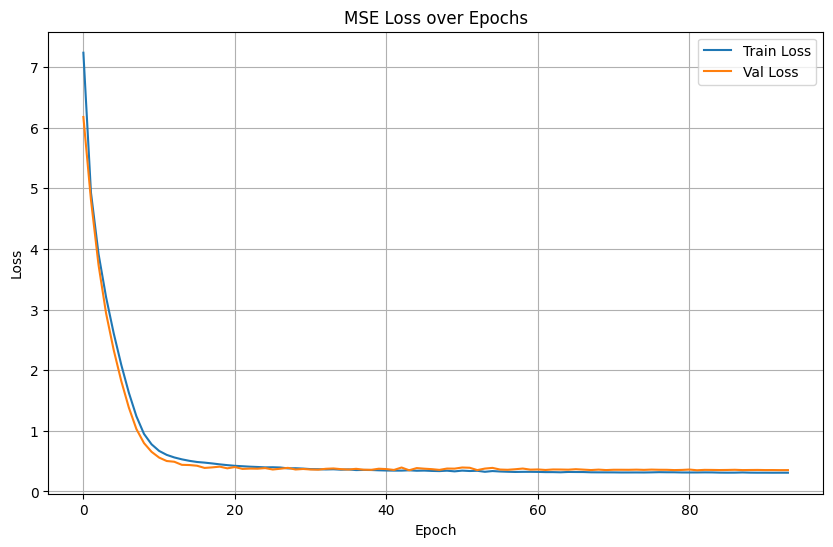

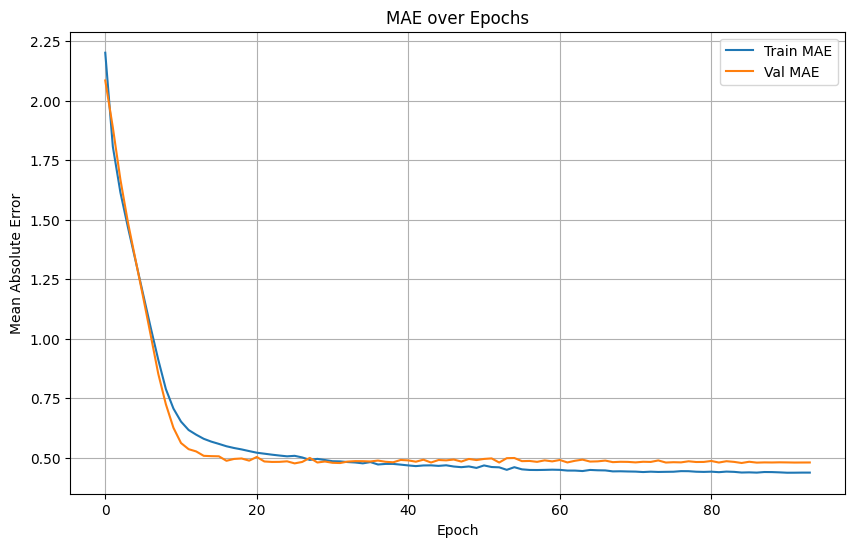

In [6]:
# plot training and validation MSE loss
plt.figure(figsize=(10, 6))
plt.plot(history_fn.history['loss'], label='Train Loss')
plt.plot(history_fn.history['val_loss'], label='Val Loss')
plt.title("MSE Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history_fn.history['mae'], label='Train MAE')
plt.plot(history_fn.history['val_mae'], label='Val MAE')
plt.title("MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# evaluate model on the test set
results = model_fn.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {results[0]:.4f}")
print(f"Test MAE: {results[1]:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3239 - mae: 0.4625 
Test Loss (MSE): 0.3492
Test MAE: 0.4806


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


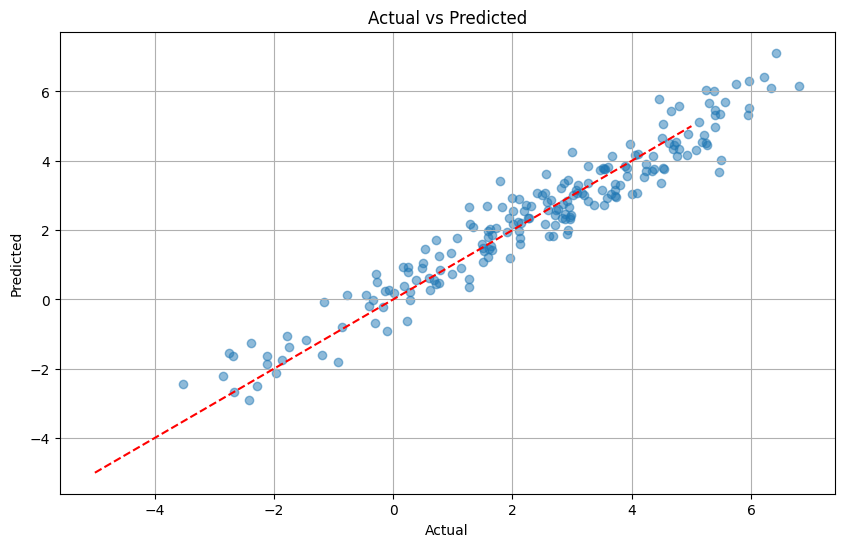

In [8]:
# predict on test set and plot actual vs predicted values
y_pred = model_fn.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), y_pred, alpha=0.5)
plt.plot([-5, 5], [-5, 5], 'r--')
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


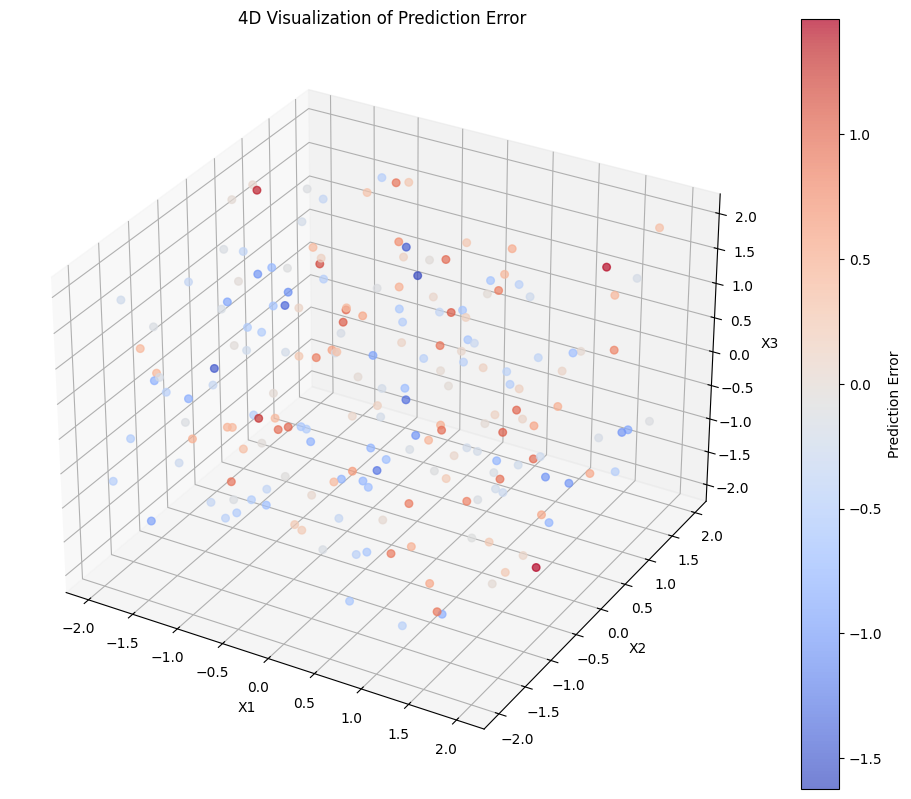

In [9]:
def show_4d_error(X, y_true, y_pred, title):
    err = y_true.numpy().flatten() - y_pred.flatten()
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=err, cmap=cm.coolwarm, s=30, alpha=0.7)
    cbar = plt.colorbar(scatter)
    cbar.set_label("Prediction Error")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X3")
    ax.set_title(title)
    plt.show()

X_vis, y_vis = make_data(200)
y_vis_pred = model_fn.predict(X_vis)
show_4d_error(X_vis.numpy(), y_vis, y_vis_pred, "4D Visualization of Prediction Error")

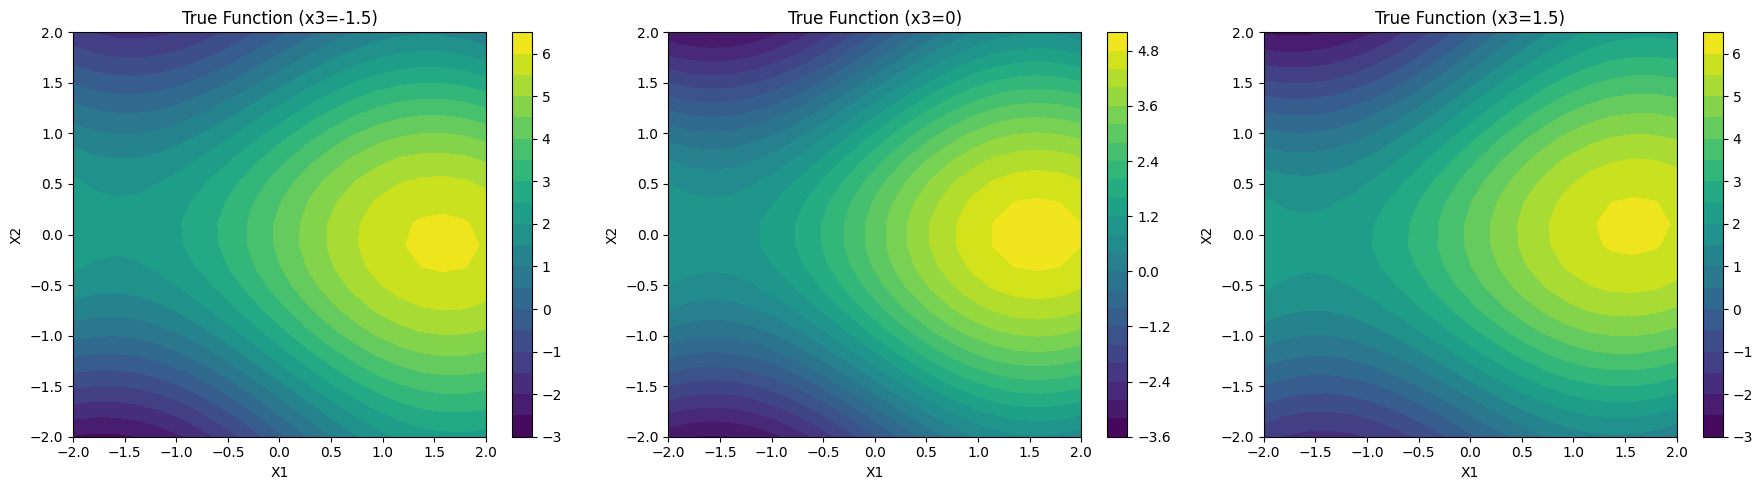

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


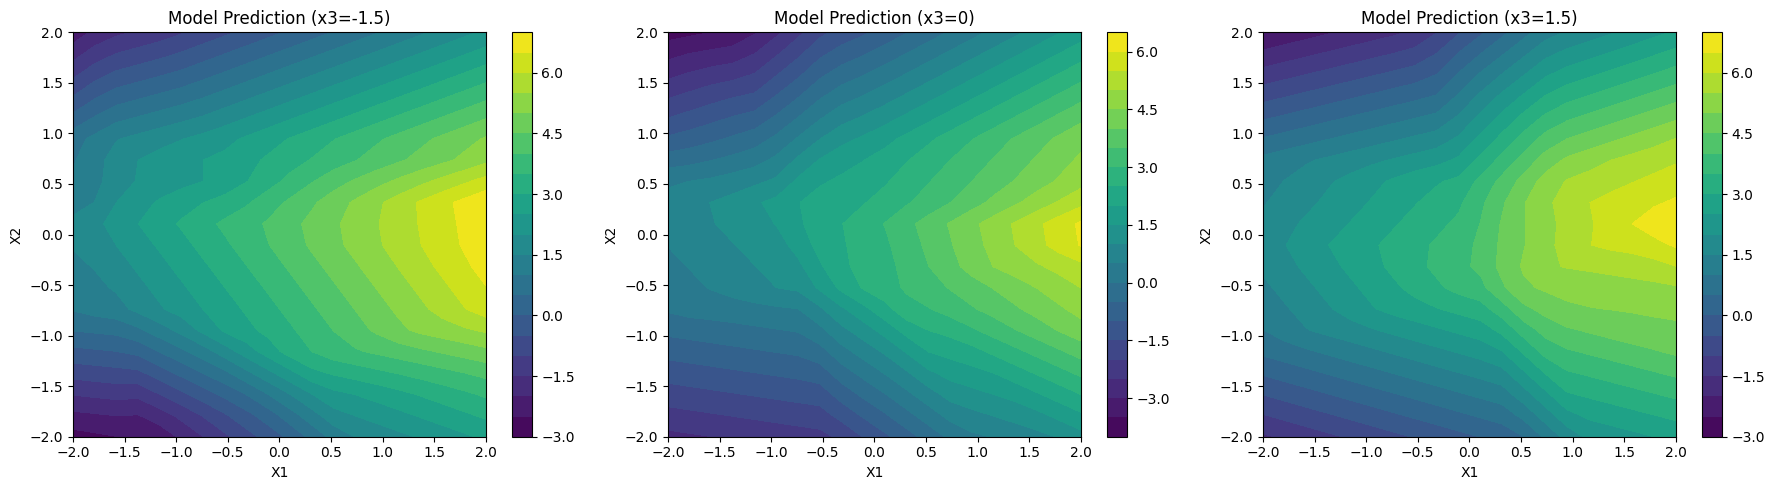

In [10]:
# visualize 2D slices by fixing x3 and plotting over x1-x2 plane
def visualize_2d_slices(span=2.0, resolution=20):
    x_vals = np.linspace(-span, span, resolution)
    fixed_vals = [-1.5, 0, 1.5]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for i, x3_fixed in enumerate(fixed_vals):
        X1, X2 = np.meshgrid(x_vals, x_vals)
        X_input = np.stack([X1.ravel(), X2.ravel(), np.full_like(X1.ravel(), x3_fixed)], axis=1)
        X_tf = tf.convert_to_tensor(X_input, dtype=tf.float32)
        y_true = nonlinear_function(X_tf).numpy().reshape(resolution, resolution)

        cs = axs[i].contourf(X1, X2, y_true, levels=20, cmap='viridis')
        axs[i].set_title(f"True Function (x3={x3_fixed})")
        axs[i].set_xlabel("X1")
        axs[i].set_ylabel("X2")
        plt.colorbar(cs, ax=axs[i])

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for i, x3_fixed in enumerate(fixed_vals):
        X1, X2 = np.meshgrid(x_vals, x_vals)
        X_input = np.stack([X1.ravel(), X2.ravel(), np.full_like(X1.ravel(), x3_fixed)], axis=1)
        X_tf = tf.convert_to_tensor(X_input, dtype=tf.float32)
        y_pred = model_fn.predict(X_tf).reshape(resolution, resolution)

        cs = axs[i].contourf(X1, X2, y_pred, levels=20, cmap='viridis')
        axs[i].set_title(f"Model Prediction (x3={x3_fixed})")
        axs[i].set_xlabel("X1")
        axs[i].set_ylabel("X2")
        plt.colorbar(cs, ax=axs[i])

    plt.tight_layout()
    plt.show()

visualize_2d_slices()